# CompIT 2025

by 0% Accuracy

## Pendahuluan dan Tujuan

Notebook ini bertujuan untuk menganalisis dan memodelkan perilaku sesi pengguna AI Assistant. Tujuan utamanya adalah untuk memprediksi `FinalOutcome` (hasil akhir sesi) berdasarkan berbagai fitur yang tersedia. Pendekatan yang digunakan meliputi:

1.  **Eksplorasi Data (EDA):** Memahami distribusi data, hubungan antar variabel, dan mendapatkan *insight* awal.
2.  **Preprocessing & Feature Engineering:** Membersihkan data dan menciptakan fitur-fitur baru yang informatif untuk meningkatkan performa model.
3.  **Pemodelan:** Melatih model klasifikasi LightGBM dengan validasi silang untuk mendapatkan prediksi yang robust.
4.  **Evaluasi:** Menganalisis performa model dan pentingnya setiap fitur.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

print("Train shape:", train.shape)
print("Test shape:", test.shape)

display(train.head())
display(test.head())

Train shape: (750000, 11)
Test shape: (250000, 10)


,uid,StudentLevel,Discipline,SessionDate,SessionLengthMin,TotalPrompts,TaskType,AI_AssistanceLevel,FinalOutcome,UsedAgain,SatisfactionRating
0,f3a0ff4e1bf1a42653555369,Graduate,Computer Science,2025-05-21,15.94,4,Coding,4,Confused,True,4.6
1,e55d03ffc0c63f9066c250b4,Undergraduate,Business,2025-06-07,29.77,4,Homework Help,3,Assignment Completed,True,3.5
2,7e3a743e6d097a5bfa794c1a,High School,History,2024-10-31,41.56,3,Homework Help,3,Assignment Completed,False,4.0
3,1a358881b7876a4dc9dbf73e,Undergraduate,Math,2024-10-04,19.95,1,Studying,5,Idea Drafted,True,2.1
4,1fd058d941a523ac77f96634,Graduate,Psychology,2025-06-10,34.14,5,Writing,1,Idea Drafted,True,3.7


,uid,StudentLevel,Discipline,SessionDate,SessionLengthMin,TotalPrompts,TaskType,AI_AssistanceLevel,UsedAgain,SatisfactionRating
0,9c9c6ffec34d6c3a4033e6a4,Undergraduate,History,2025-02-18,10.74,2,Coding,4,True,3.0
1,40d7a55e1cfffde0ced5a3cc,Graduate,Psychology,2024-12-29,28.14,9,Studying,3,True,3.1
2,50597596cb5309596488d65d,Undergraduate,Biology,2024-08-10,43.52,3,Homework Help,3,True,4.0
3,318af55a0ecbf2469de67fb8,Undergraduate,Business,2025-03-09,20.10,4,Writing,3,True,2.3
4,19ec6a5c8d382c8d05354cd3,Graduate,Biology,2025-05-25,15.14,2,Studying,3,True,3.8


In [3]:
train.info()
train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   uid                 750000 non-null  object 
 1   StudentLevel        750000 non-null  object 
 2   Discipline          750000 non-null  object 
 3   SessionDate         750000 non-null  object 
 4   SessionLengthMin    750000 non-null  float64
 5   TotalPrompts        750000 non-null  int64  
 6   TaskType            750000 non-null  object 
 7   AI_AssistanceLevel  750000 non-null  int64  
 8   FinalOutcome        750000 non-null  object 
 9   UsedAgain           750000 non-null  bool   
 10  SatisfactionRating  750000 non-null  float64
dtypes: bool(1), float64(2), int64(2), object(6)
memory usage: 57.9+ MB


uid                   0
StudentLevel          0
Discipline            0
SessionDate           0
SessionLengthMin      0
TotalPrompts          0
TaskType              0
AI_AssistanceLevel    0
FinalOutcome          0
UsedAgain             0
SatisfactionRating    0
dtype: int64

## EDA

### Analisis Variabel Target

Distribusi Kelas FinalOutcome:
FinalOutcome
Assignment Completed    359666
Idea Drafted            216846
Confused                120869
Gave Up                  52619
Name: count, dtype: int64

Distribusi Persentase (%):
FinalOutcome
Assignment Completed    47.955467
Idea Drafted            28.912800
Confused                16.115867
Gave Up                  7.015867
Name: proportion, dtype: float64


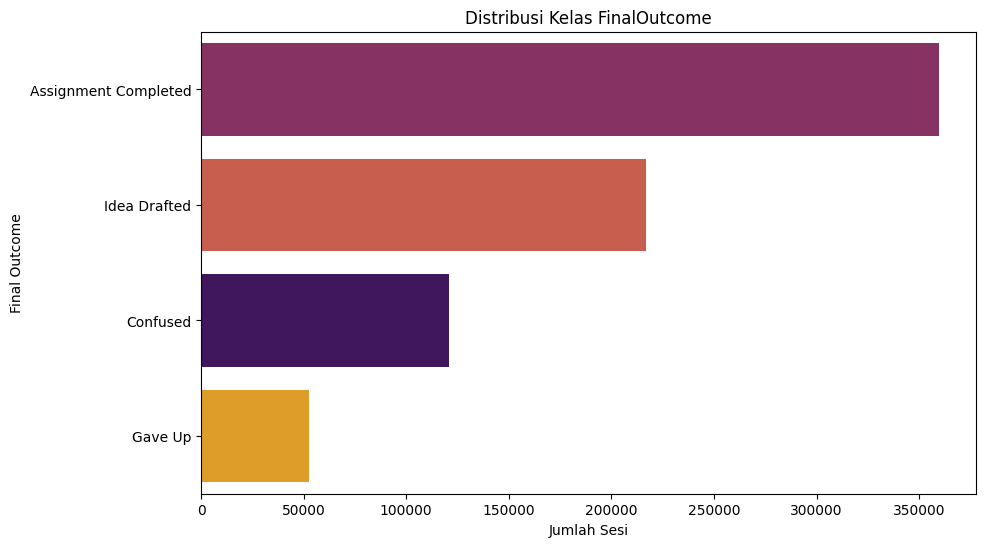

In [4]:
outcome_counts = train['FinalOutcome'].value_counts()
outcome_percentages = train['FinalOutcome'].value_counts(normalize=True) * 100

print("Distribusi Kelas FinalOutcome:")
print(outcome_counts)
print("\nDistribusi Persentase (%):")
print(outcome_percentages)

plt.figure(figsize=(10, 6))
sns.countplot(y=train['FinalOutcome'], order=outcome_counts.index, hue=train['FinalOutcome'], palette='inferno')
plt.title('Distribusi Kelas FinalOutcome')
plt.xlabel('Jumlah Sesi')
plt.ylabel('Final Outcome')
plt.show()

visualisasi distribusi diatas bertujuan untuk mengetahui apakah data yang diberikan imbalanced? Artinya, kita harus menggunakan teknik seperti stratified cross-validation dan mungkin class weighting saat modeling nanti. Karena Macro F1 sangat sensitif terhadap ini. Dari visualisasi tersebut terlihat bahwa datanya kurang balanced. dapat dilihat dari persentase distribusinya

### Analisis Fitur Numerik


Distribusi Fitur Numerik:


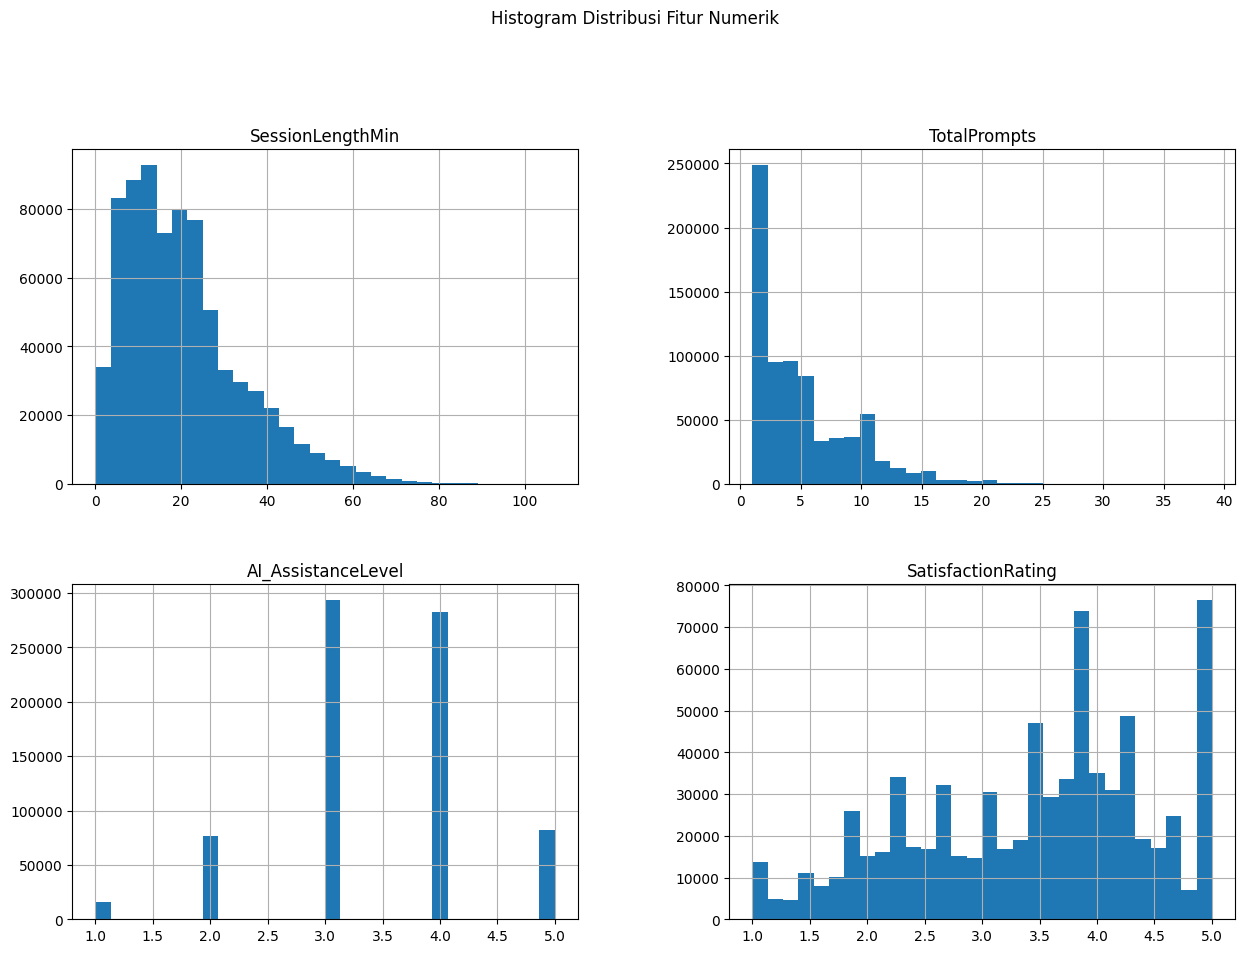


Box Plot Fitur Numerik vs. FinalOutcome:


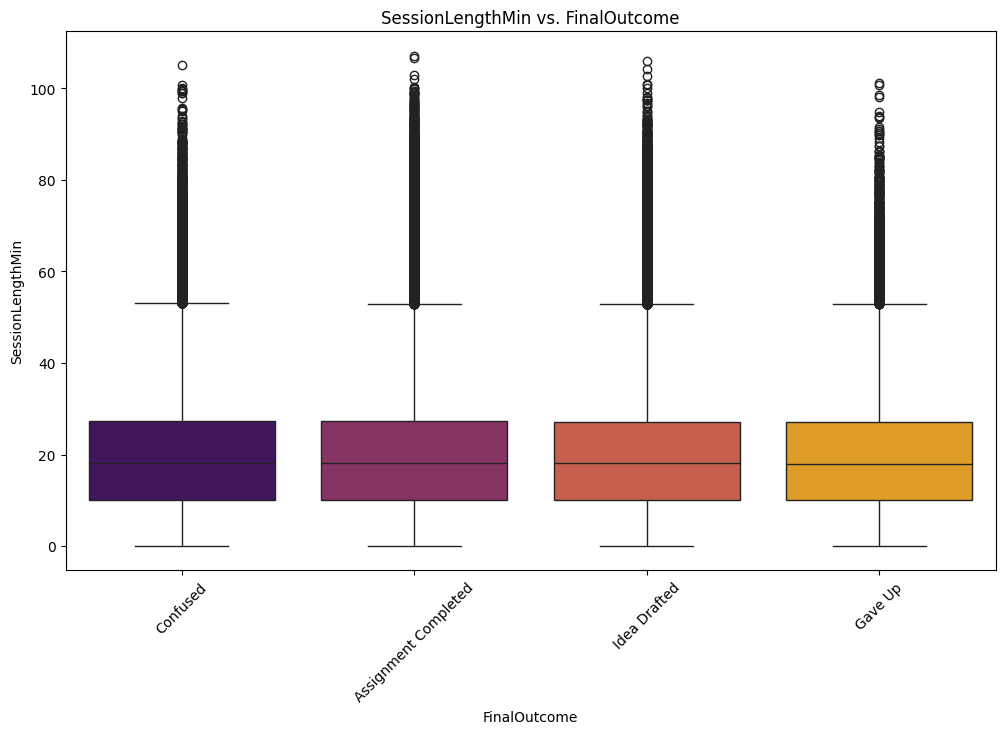

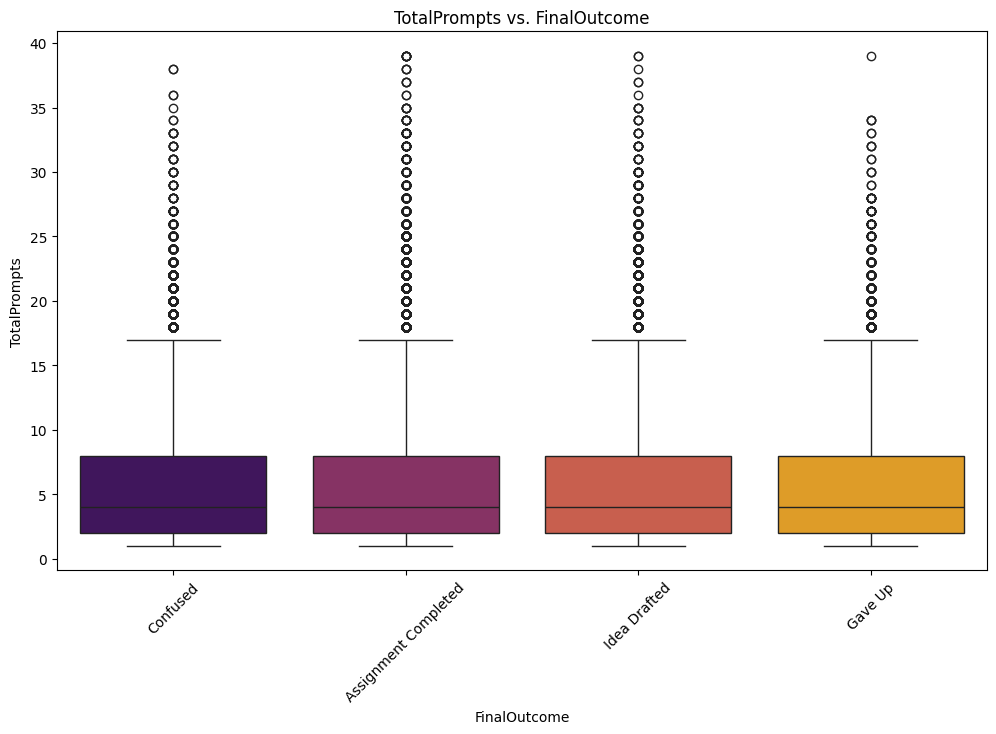

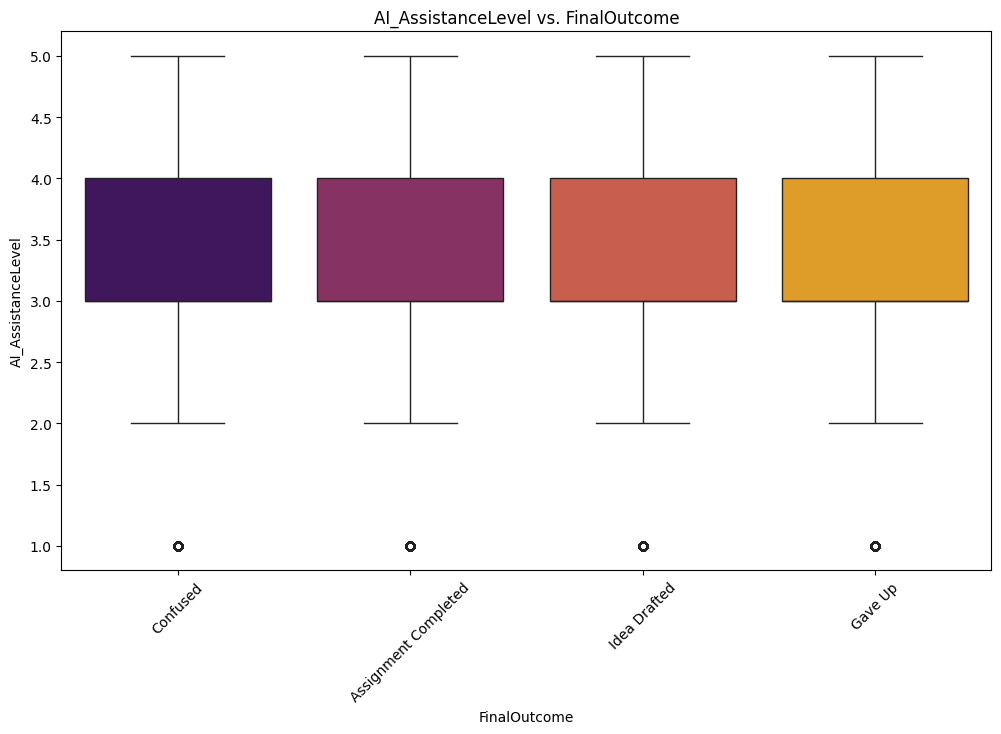

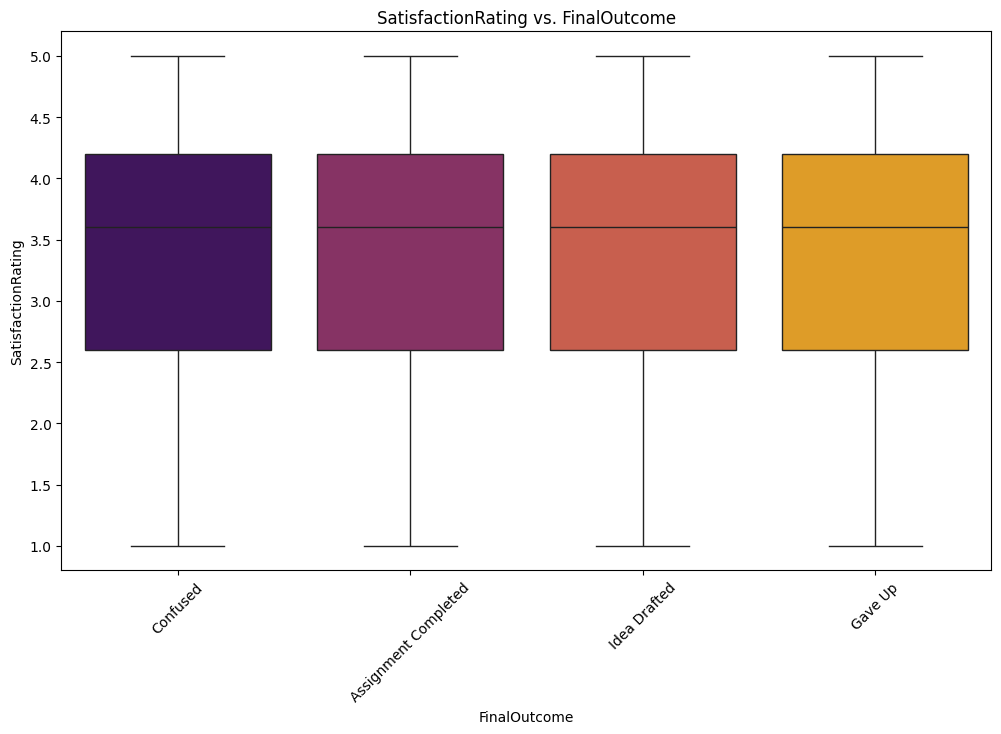

In [5]:
numerical_features = ['SessionLengthMin', 'TotalPrompts', 'AI_AssistanceLevel', 'SatisfactionRating']

print("\nDistribusi Fitur Numerik:")
train[numerical_features].hist(bins=30, figsize=(15, 10), layout=(2, 2))
plt.suptitle('Histogram Distribusi Fitur Numerik', y=1.02)
plt.show()

print("\nBox Plot Fitur Numerik vs. FinalOutcome:")
for col in numerical_features:
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='FinalOutcome', y=col, data=train, hue='FinalOutcome', palette='inferno')
    plt.title(f'{col} vs. FinalOutcome')
    plt.xticks(rotation=45)
    plt.show()

- SessionLengthMin dan TotalPrompts distribusinya right-skewed.
- AI_AssistanceLevel secara jumlah distribusi mayoritas berada di level 3(paling banyak) dan 4, lalu turun ke 5, 2, 1
- Mengenai satisfaction rating berdasarkan box plot, semuanya sama
- dari 4 box plot yang divisualisasikan mengenai hubungan numerical features dan final outcome. sangat mirip hasilnya dari confused sampai gave up
- Mengenai totalprompts secara visualisasi bentuknya juga mirip" antar level final outcome. hanya berbeda di outliernya saja dan itupun mirip" juga. assignment complete memiliki outlier yang sedikit lebih tinggi dibandingkan lainnya

### Analisis Fitur Kategorikal

--- StudentLevel ---
StudentLevel
Undergraduate    443683
Graduate         153986
High School      152331
Name: count, dtype: int64


--- Discipline ---
Discipline
Biology             109273
Computer Science    108834
Engineering         107383
Psychology          106832
History             106424
Business            105719
Math                105535
Name: count, dtype: int64


--- TaskType ---
TaskType
Writing          235486
Studying         155096
Homework Help    148356
Coding           146642
Research          32822
Brainstorming     31598
Name: count, dtype: int64


--- UsedAgain ---
UsedAgain
True     532276
False    217724
Name: count, dtype: int64



Visualisasi Fitur Kategorikal vs. FinalOutcome:


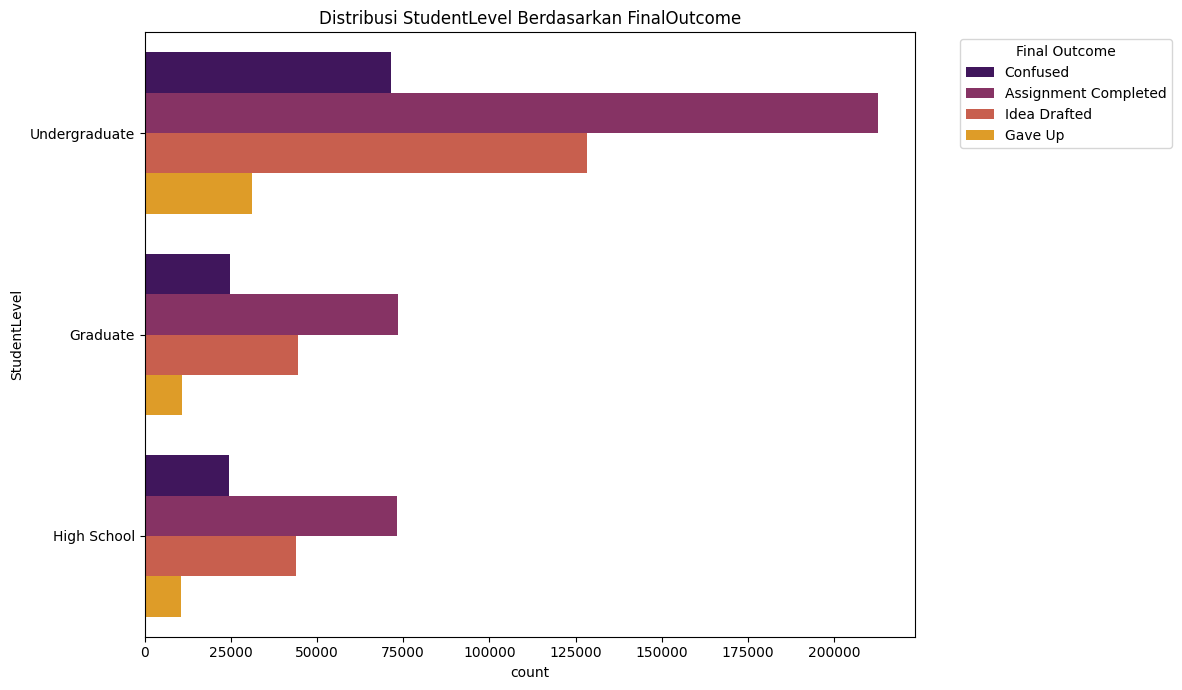

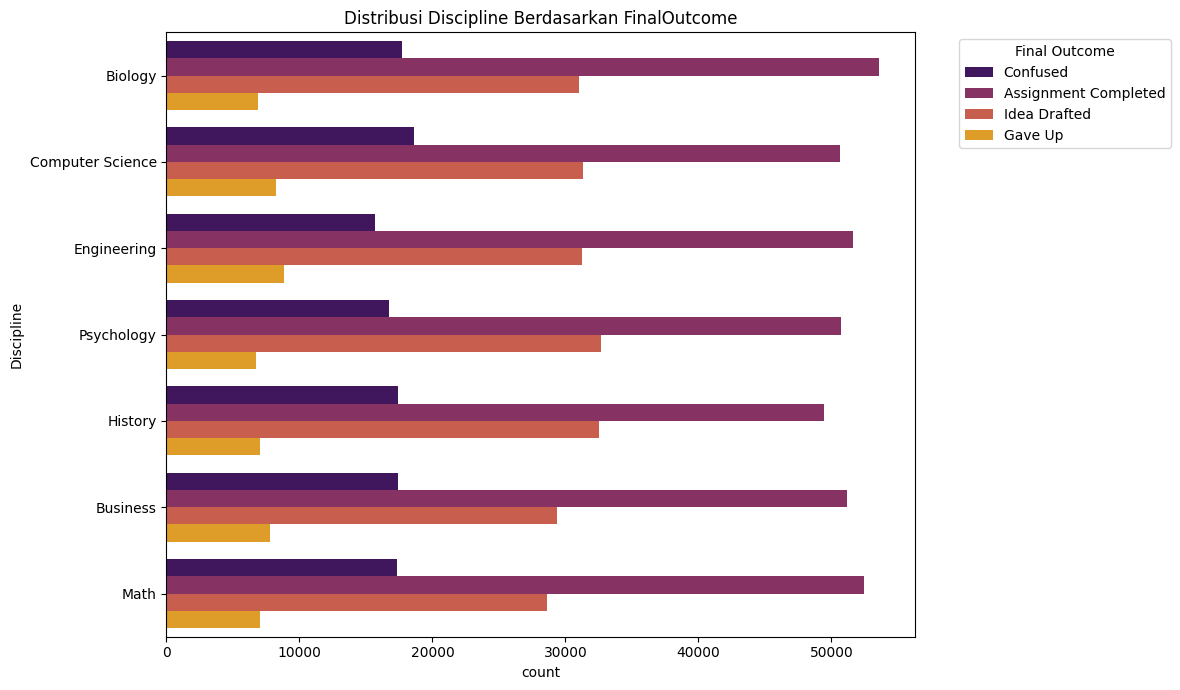

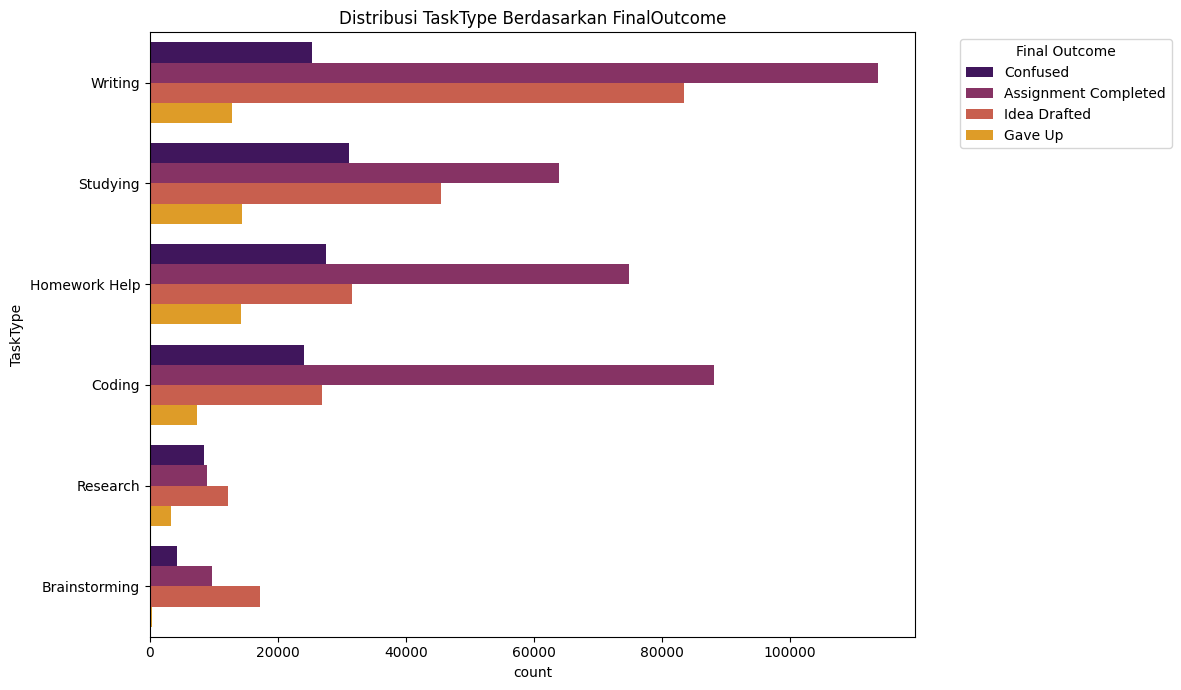

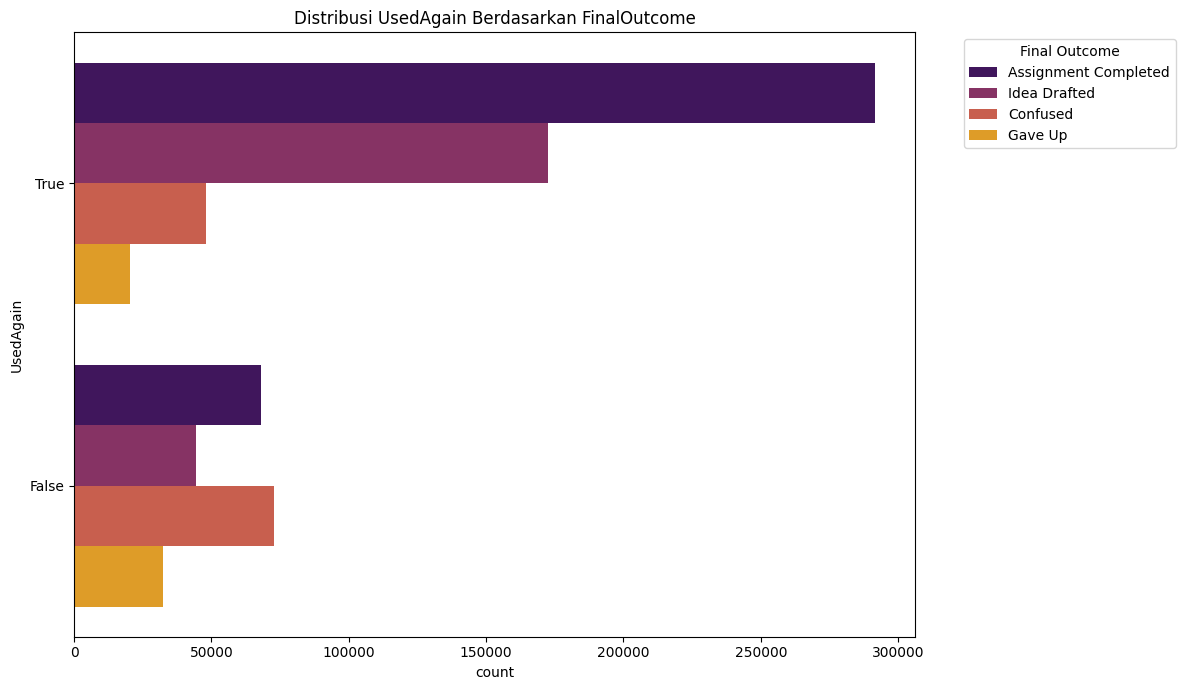

In [6]:
categorical_features = ['StudentLevel', 'Discipline', 'TaskType', 'UsedAgain']

for col in categorical_features:
    print(f"--- {col} ---")
    print(train[col].value_counts())
    print("\n")

print("\nVisualisasi Fitur Kategorikal vs. FinalOutcome:")
for col in categorical_features:
    plt.figure(figsize=(12, 7))
    sns.countplot(data=train, y=col, hue='FinalOutcome', order=train[col].value_counts().index, palette='inferno')
    plt.title(f'Distribusi {col} Berdasarkan FinalOutcome')
    plt.legend(title='Final Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

#### Insight

- writing dan coding merupakan task type tertinggi untuk assignment completed lalu disusul oleh homework help dan studying. pendapat kami adalah karena gen AI lebih mudah mempelajari teks sehingga writing dan coding merupakan hal yang lebih mudah dibantu oleh AI dibanding yang lainnya. sedangkan riset juga bisa dibilang mayoritas teks. tapi sumbernya tidak sebanyak itu yang open source jika dibandingkan dgn yg lain.

- untuk idea drafted di beberapa task type seperti brainstorming dan research menunjukkan final outcome yang lebih banyak dibandingkan final outcome lainnya. menurut kami output dari brainstorming adalah ide, sehingga lebih condong ke idea drafted. serta di research yang penting adalah ide awalnya. 

- dari segi perbandingan final outcome antara graduate dengan undergraduate sama" saja, lebih banyak yang assignment completed. menurut saya kenapa jumlah undergraduate lebih banyak secara visual adalah karena jumlah data undergraduate lebih banyak. insight yang kami dapatkan juga adalah karena yang saat ini undergraduate masih menjadi mahasiswa sehingga lebih up to date secara tren

- `UsedAgain == true` lebih banyak yang hasilnya positif seperti assignment completed dan idea drafted sedangkan ketika false final outcome yang lebih banyak adalah confused dibandingkan lainnya. dapat dikatakan bahwa ketika orang menggunakan AI dan hasilnya kurang sesuai ekspektasi mereka entah karena prompt yang kurang baik atau lainnya berpengaruh terhadap kegunaan AI secara berkelajutan

### Analisa Tanggal

Rentang tanggal: 2024-06-24 00:00:00 sampai 2025-06-24 00:00:00


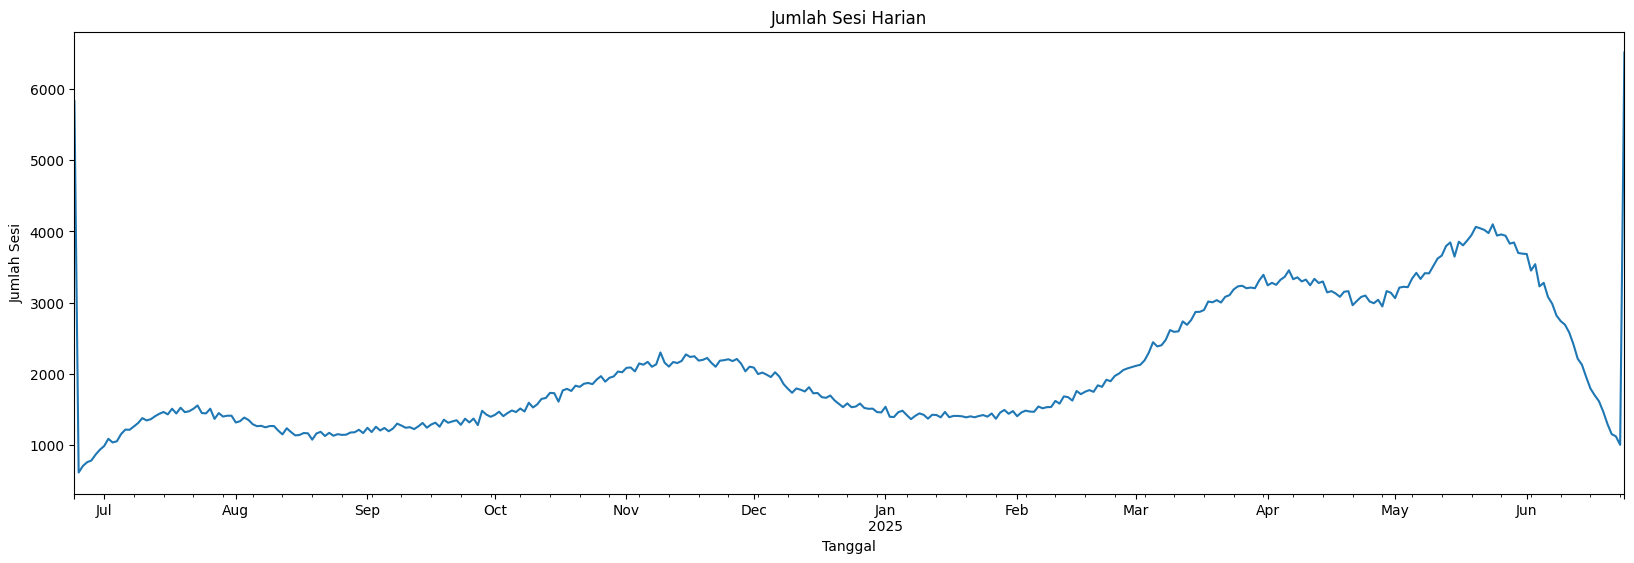

In [7]:
train['SessionDate'] = pd.to_datetime(train['SessionDate'])

# Cek rentang tanggal
print(f"Rentang tanggal: {train['SessionDate'].min()} sampai {train['SessionDate'].max()}")

# Buat plot jumlah sesi per hari
plt.figure(figsize=(20, 6))
train.set_index('SessionDate')['uid'].resample('D').count().plot()
plt.title('Jumlah Sesi Harian')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Sesi')
plt.show()

**Setelah melakukan analisis mendalam terhadap tren penggunaan AI asisten dari waktu ke waktu, saya menemukan korelasi yang sangat kuat dengan kalender akademik. Berikut poin-poinnya:**

- Fase Awal Semester Ganjil *(Juli - September 2024)*: Saya melihat adanya kenaikan aktivitas yang diikuti oleh fase stabil. Ini sangat cocok dengan periode adaptasi mahasiswa di awal semester baru, di mana tugas-tugas mulai diberikan.
- Puncak Tengah Semester *(September - Pertengahan November 2024)*: Tren menunjukkan peningkatan yang konsisten. Di mana beban tugas, proyek, dan persiapan Ujian Tengah Semester (UTS) memuncak, mendorong penggunaan AI secara signifikan.
- Musim Ujian Akhir & Libur Panjang *(Pertengahan November 2024 - Februari 2025)*: Pola ini adalah bukti terkuat. Saya mengamati penurunan tajam setelah puncak Ujian Akhir Semester (UAS), dengan titik terendah terjadi pada Desember-Januari. Ini secara langsung merefleksikan periode libur semester di mana aktivitas akademik berhenti.
- Lonjakan Aktivitas Semester Genap *(Februari - Juni 2025)*: Saya melihat lonjakan penggunaan yang paling drastis terjadi di awal semester ini. Fluktuasi di periode ini, termasuk puncak kedua di akhir semester, sangat sesuai dengan ritme UTS dan UAS pada semester genap.
- Periode Transisi *(Akhir Juni 2025)*: Pola penurunan tajam yang diikuti kenaikan cepat di akhir bulan saya simpulkan sebagai transisi dari akhir semester reguler ke dimulainya semester pendek atau proyek/magang musim panas.

Kesimpulan: Analisis ini mengonfirmasi bahwa fitur-fitur turunan dari SessionDate bukanlah sekadar data temporal, melainkan proksi yang sangat kuat untuk beban kerja akademik mahasiswa. Ini adalah informasi krusial yang akan saya manfaatkan dalam feature engineering untuk meningkatkan performa model.

## Preprocessing & Feature Engineering

## Kesesuaian Teknik Pre-processing & Feature Engineering

Berdasarkan *insight* dari EDA, kami melakukan serangkaian transformasi dan pembuatan fitur baru untuk memberikan informasi yang lebih kaya dan kontekstual kepada model.

### Persiapan Awal untuk Preprocessing

Sebelum menggabungkan data, kita pisahkan terlebih dahulu kolom `uid` dari data test (untuk file submisi akhir) dan kolom target `FinalOutcome` dari data train.

In [8]:
# UID test untuk file submisi akhir
test_uids = test['uid']
# Target variable
target = train['FinalOutcome']

### Menggabungkan Data Train dan Test

Data training dan testing digabungkan menjadi satu `DataFrame`. Langkah ini sangat penting untuk menyederhanakan dan mengefisienkan proses *feature engineering*. Dengan bekerja pada satu `DataFrame`, kita dapat memastikan bahwa semua transformasi dan fitur baru diterapkan secara konsisten pada kedua set data.

In [9]:
combined_df = pd.concat([train.drop('FinalOutcome', axis=1), test], ignore_index=True)

print("Bentuk data training:", train.shape)
print("Bentuk data testing:", test.shape)
print("Bentuk data gabungan:", combined_df.shape)

Bentuk data training: (750000, 11)
Bentuk data testing: (250000, 10)
Bentuk data gabungan: (1000000, 10)


### Feature Engineering

### 1. Fitur Temporal

Kolom `SessionDate` diubah menjadi tipe `datetime`. Dari sini, fitur-fitur temporal baru diekstrak, seperti hari dalam seminggu, hari dalam setahun, bulan, dan minggu dalam setahun. Fitur `is_weekend` juga dibuat untuk menangkap pola perilaku yang mungkin berbeda pada akhir pekan.

In [10]:
# Konversi SessionDate ke tipe datetime
combined_df['SessionDate'] = pd.to_datetime(combined_df['SessionDate'])

# Ekstrak fitur-fitur temporal
combined_df['day_of_week'] = combined_df['SessionDate'].dt.dayofweek  # Senin=0, Minggu=6
combined_df['day_of_year'] = combined_df['SessionDate'].dt.dayofyear
combined_df['month'] = combined_df['SessionDate'].dt.month
combined_df['week_of_year'] = combined_df['SessionDate'].dt.isocalendar().week.astype(int)
combined_df['is_weekend'] = (combined_df['day_of_week'] >= 5).astype(int) # 1 jika weekend, 0 jika tidak

print("Fitur baru dari SessionDate berhasil dibuat:")
display(combined_df[['SessionDate', 'day_of_week', 'day_of_year', 'month', 'week_of_year', 'is_weekend']].head())

Fitur baru dari SessionDate berhasil dibuat:


,SessionDate,day_of_week,day_of_year,month,week_of_year,is_weekend
0,2025-05-21,2,141,5,21,0
1,2025-06-07,5,158,6,23,1
2,2024-10-31,3,305,10,44,0
3,2024-10-04,4,278,10,40,0
4,2025-06-10,1,161,6,24,0


### 2. Fitur Interaksi

Fitur interaksi dibuat untuk menangkap hubungan yang lebih kompleks antar variabel:
-   **`prompts_per_minute`**: Mengukur efisiensi atau intensitas sesi. Nilai yang sangat rendah bisa mengindikasikan pengguna kesulitan.
-   **`satisfaction_gap`**: Mengukur perbedaan antara tingkat bantuan AI (`AI_AssistanceLevel`) dengan kepuasan pengguna. Kesenjangan yang besar bisa menjadi prediktor kuat.

In [11]:
epsilon = 1e-6

# Fitur 1: Intensitas Sesi (Prompts per Menit)
combined_df['prompts_per_minute'] = combined_df['TotalPrompts'] / (combined_df['SessionLengthMin'] + epsilon)

# Fitur 2: Kesenjangan Kepuasan
combined_df['satisfaction_gap'] = combined_df['SatisfactionRating'] - combined_df['AI_AssistanceLevel']

display(combined_df[['TotalPrompts', 'SessionLengthMin', 'prompts_per_minute', 'SatisfactionRating', 'AI_AssistanceLevel', 'satisfaction_gap']].head())

,TotalPrompts,SessionLengthMin,prompts_per_minute,SatisfactionRating,AI_AssistanceLevel,satisfaction_gap
0,4,15.94,0.250941,4.6,4,0.6
1,4,29.77,0.134363,3.5,3,0.5
2,3,41.56,0.072185,4.0,3,1.0
3,1,19.95,0.050125,2.1,5,-2.9
4,5,34.14,0.146456,3.7,1,2.7


### 3. Transformasi Log

Fitur `SessionLengthMin` dan `TotalPrompts` memiliki distribusi yang *skewed*. Transformasi `log1p` (log(1+x)) diterapkan untuk menormalkan distribusi ini. Hal ini membantu model, terutama yang berbasis pohon seperti LightGBM, untuk menemukan titik pemisahan yang lebih baik.

In [12]:
# Transformasi log1p pada fitur yang skewed (right-skewed) berdasarkan EDA sebelumnya
skewed_features = ['SessionLengthMin', 'TotalPrompts']
for col in skewed_features:
    combined_df[col + '_log'] = np.log1p(combined_df[col])

print("\nHasil transformasi log berhasil dibuat:")
display(combined_df[['SessionLengthMin', 'SessionLengthMin_log', 'TotalPrompts', 'TotalPrompts_log']].head())


Hasil transformasi log berhasil dibuat:


,SessionLengthMin,SessionLengthMin_log,TotalPrompts,TotalPrompts_log
0,15.94,2.829678,4,1.609438
1,29.77,3.426540,4,1.609438
2,41.56,3.750915,3,1.386294
3,19.95,3.042139,1,0.693147
4,34.14,3.559340,5,1.791759


### 4. Fitur Agregat dan Relatif

Ini adalah bagian paling krusial dari *feature engineering*. Fitur agregat (seperti `mean`, `std`, `max`) dihitung untuk grup-grup kategorikal (`Discipline`, `TaskType`, `StudentLevel`). Fitur-fitur ini memberikan **konteks** kepada model.

Selanjutnya, fitur relatif (perbedaan, rasio, dan z-score) dibuat untuk secara eksplisit mengukur seberapa jauh deviasi sebuah sesi dari rata-rata grupnya. Fitur ini sangat kuat karena menangkap perilaku anomali.

In [13]:
# Fitur Agregat Berdasarkan 'Discipline'
discipline_stats = combined_df.groupby('Discipline').agg({
    'SessionLengthMin': ['mean', 'std', 'max'],
    'TotalPrompts': ['mean', 'std', 'max'],
    'AI_AssistanceLevel': ['mean', 'median'],
    'SatisfactionRating': ['mean', 'median']
}).round(4)

# Flatten kolom multi-level
discipline_stats.columns = ['discipline_' + '_'.join(col).strip() for col in discipline_stats.columns.values]
discipline_stats.reset_index(inplace=True)

# Fitur Agregat Berdasarkan 'TaskType'
task_stats = combined_df.groupby('TaskType').agg({
    'SessionLengthMin': ['mean', 'std'],
    'TotalPrompts': ['mean', 'std'], 
    'AI_AssistanceLevel': ['mean', 'median'],
    'SatisfactionRating': ['mean', 'median']
}).round(4)

task_stats.columns = ['task_' + '_'.join(col).strip() for col in task_stats.columns.values]
task_stats.reset_index(inplace=True)

# Fitur Agregat Berdasarkan 'StudentLevel'
student_stats = combined_df.groupby('StudentLevel').agg({
    'SessionLengthMin': ['mean', 'median'],
    'TotalPrompts': ['mean', 'median'],
    'prompts_per_minute': ['mean', 'std']
}).round(4)

student_stats.columns = ['student_' + '_'.join(col).strip() for col in student_stats.columns.values]
student_stats.reset_index(inplace=True)

# Gabungkan fitur agregat ke dataframe utama
combined_df = combined_df.merge(discipline_stats, on='Discipline', how='left')
combined_df = combined_df.merge(task_stats, on='TaskType', how='left')
combined_df = combined_df.merge(student_stats, on='StudentLevel', how='left')

print("Fitur agregat berhasil ditambahkan!")
print("Bentuk data setelah penambahan fitur agregat:", combined_df.shape)

# Tampilkan beberapa fitur baru
display(combined_df[['Discipline', 'discipline_SessionLengthMin_mean', 'discipline_TotalPrompts_std', 
                     'TaskType', 'task_AI_AssistanceLevel_mean']].head())

Fitur agregat berhasil ditambahkan!
Bentuk data setelah penambahan fitur agregat: (1000000, 43)


,Discipline,discipline_SessionLengthMin_mean,discipline_TotalPrompts_std,TaskType,task_AI_AssistanceLevel_mean
0,Computer Science,20.5672,4.1968,Coding,3.4513
1,Business,20.6040,4.1749,Homework Help,3.4518
2,History,20.5255,4.1921,Homework Help,3.4518
3,Math,20.5221,4.1892,Studying,3.4516
4,Psychology,20.5764,4.1882,Writing,3.4538


In [14]:
# Fitur Relatif terhadap Discipline
combined_df['session_vs_discipline_avg'] = combined_df['SessionLengthMin'] - combined_df['discipline_SessionLengthMin_mean']
combined_df['prompts_vs_discipline_avg'] = combined_df['TotalPrompts'] - combined_df['discipline_TotalPrompts_mean']
combined_df['satisfaction_vs_discipline_avg'] = combined_df['SatisfactionRating'] - combined_df['discipline_SatisfactionRating_mean']
combined_df['ai_assist_vs_discipline_avg'] = combined_df['AI_AssistanceLevel'] - combined_df['discipline_AI_AssistanceLevel_mean']

# Fitur Relatif terhadap TaskType  
combined_df['session_vs_task_avg'] = combined_df['SessionLengthMin'] - combined_df['task_SessionLengthMin_mean']
combined_df['prompts_vs_task_avg'] = combined_df['TotalPrompts'] - combined_df['task_TotalPrompts_mean']
combined_df['satisfaction_vs_task_avg'] = combined_df['SatisfactionRating'] - combined_df['task_SatisfactionRating_mean']
combined_df['ai_assist_vs_task_avg'] = combined_df['AI_AssistanceLevel'] - combined_df['task_AI_AssistanceLevel_mean']

# Fitur Relatif terhadap StudentLevel
combined_df['session_vs_student_avg'] = combined_df['SessionLengthMin'] - combined_df['student_SessionLengthMin_mean']
combined_df['prompts_vs_student_avg'] = combined_df['TotalPrompts'] - combined_df['student_TotalPrompts_mean']
combined_df['prompts_per_min_vs_student_avg'] = combined_df['prompts_per_minute'] - combined_df['student_prompts_per_minute_mean']

# Fitur Rasio (nilai individu / rata-rata grup)
epsilon = 1e-6  # Untuk menghindari pembagian dengan 0

combined_df['session_ratio_discipline'] = combined_df['SessionLengthMin'] / (combined_df['discipline_SessionLengthMin_mean'] + epsilon)
combined_df['prompts_ratio_discipline'] = combined_df['TotalPrompts'] / (combined_df['discipline_TotalPrompts_mean'] + epsilon)
combined_df['session_ratio_task'] = combined_df['SessionLengthMin'] / (combined_df['task_SessionLengthMin_mean'] + epsilon)
combined_df['prompts_ratio_task'] = combined_df['TotalPrompts'] / (combined_df['task_TotalPrompts_mean'] + epsilon)

# Fitur Z-Score (standardized difference)
combined_df['session_zscore_discipline'] = (combined_df['SessionLengthMin'] - combined_df['discipline_SessionLengthMin_mean']) / (combined_df['discipline_SessionLengthMin_std'] + epsilon)
combined_df['prompts_zscore_discipline'] = (combined_df['TotalPrompts'] - combined_df['discipline_TotalPrompts_mean']) / (combined_df['discipline_TotalPrompts_std'] + epsilon)
combined_df['session_zscore_task'] = (combined_df['SessionLengthMin'] - combined_df['task_SessionLengthMin_mean']) / (combined_df['task_SessionLengthMin_std'] + epsilon)
combined_df['prompts_zscore_task'] = (combined_df['TotalPrompts'] - combined_df['task_TotalPrompts_mean']) / (combined_df['task_TotalPrompts_std'] + epsilon)

print("Fitur relatif berhasil dibuat!")
print(f"Bentuk data setelah penambahan fitur relatif: {combined_df.shape}")

# Tampilkan beberapa fitur relatif baru
display(combined_df[['SessionLengthMin', 'discipline_SessionLengthMin_mean', 'session_vs_discipline_avg', 
                     'session_ratio_discipline', 'session_zscore_discipline']].head())

Fitur relatif berhasil dibuat!
Bentuk data setelah penambahan fitur relatif: (1000000, 62)


,SessionLengthMin,discipline_SessionLengthMin_mean,session_vs_discipline_avg,session_ratio_discipline,session_zscore_discipline
0,15.94,20.5672,-4.6272,0.775020,-0.333060
1,29.77,20.6040,9.1660,1.444865,0.657094
2,41.56,20.5255,21.0345,2.024798,1.517071
3,19.95,20.5221,-0.5721,0.972123,-0.041146
4,34.14,20.5764,13.5636,1.659182,0.974866


### Encoding (Categorical Data)

### 5. Ordinal Encoding

Untuk `StudentLevel`, digunakan *Ordinal Encoding* manual karena ada urutan yang jelas dan bermakna (`High School` < `Undergraduate` < `Graduate`). Ini memberikan sinyal tingkatan kepada model.

In [15]:
# Ordinal encoding untuk kolom StudentLevel

level_mapping = ['High School', 'Undergraduate', 'Graduate']
combined_df['StudentLevel_encoded'] = combined_df['StudentLevel'].apply(lambda x: level_mapping.index(x))

display(combined_df[['StudentLevel', 'StudentLevel_encoded']].head())

,StudentLevel,StudentLevel_encoded
0,Graduate,2
1,Undergraduate,1
2,High School,0
3,Undergraduate,1
4,Graduate,2


### 6. One-Hot Encoding

Untuk `Discipline` dan `TaskType`, digunakan *One-Hot Encoding* karena tidak ada urutan inheren antar kategorinya. Metode ini membuat kolom biner baru untuk setiap kategori, mencegah model mengasumsikan hubungan ordinal yang salah.

In [16]:
# One-Hot Encoding untuk kolom yang tidak memiliki urutan inheren
categorical_to_encode = ['Discipline', 'TaskType']
combined_df = pd.get_dummies(combined_df, columns=categorical_to_encode, prefix=categorical_to_encode)

display(combined_df.head())


,uid,StudentLevel,SessionDate,SessionLengthMin,TotalPrompts,AI_AssistanceLevel,UsedAgain,SatisfactionRating,day_of_week,day_of_year,...,Discipline_Engineering,Discipline_History,Discipline_Math,Discipline_Psychology,TaskType_Brainstorming,TaskType_Coding,TaskType_Homework Help,TaskType_Research,TaskType_Studying,TaskType_Writing
0,f3a0ff4e1bf1a42653555369,Graduate,2025-05-21,15.94,4,4,True,4.6,2,141,...,False,False,False,False,False,True,False,False,False,False
1,e55d03ffc0c63f9066c250b4,Undergraduate,2025-06-07,29.77,4,3,True,3.5,5,158,...,False,False,False,False,False,False,True,False,False,False
2,7e3a743e6d097a5bfa794c1a,High School,2024-10-31,41.56,3,3,False,4.0,3,305,...,False,True,False,False,False,False,True,False,False,False
3,1a358881b7876a4dc9dbf73e,Undergraduate,2024-10-04,19.95,1,5,True,2.1,4,278,...,False,False,True,False,False,False,False,False,True,False
4,1fd058d941a523ac77f96634,Graduate,2025-06-10,34.14,5,1,True,3.7,1,161,...,False,False,False,True,False,False,False,False,False,True


In [17]:
# Konversi UsedAgain yang sebelumnya boolean menjadi int (0 dan 1)

combined_df['UsedAgain'] = combined_df['UsedAgain'].astype(int)
print("Tipe data UsedAgain setelah diubah:", combined_df['UsedAgain'].dtype)

Tipe data UsedAgain setelah diubah: int64


### Cleaning Data

### Finalisasi Set Fitur

Kolom-kolom asli yang sudah tidak relevan (karena telah ditransformasi atau di-encode) dihapus untuk mengurangi redundansi. `DataFrame` kemudian dipisahkan kembali menjadi set `X` (fitur training) dan `X_test` (fitur testing).

In [18]:
# Hapus kolom yang sudah di-transformasi atau tidak relevan lagi
columns_to_drop = ['uid', 'StudentLevel', 'SessionDate', 'SessionLengthMin', 'TotalPrompts']
df_processed = combined_df.drop(columns=columns_to_drop)

# Pisahkan kembali menjadi train dan test
X = df_processed[:len(train)] # train
X_test = df_processed[len(train):] # test

### Encoding Variabel Target

Variabel target `FinalOutcome` yang bertipe string dikonversi menjadi nilai numerik (0, 1, 2, 3) menggunakan `LabelEncoder`, sesuai dengan format yang dibutuhkan oleh model.

In [19]:
# Konversi target 'FinalOutcome' menjadi numerik menggunakan LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(target)

In [20]:
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Pemetaan Label Target:", label_mapping)

print("Bentuk data training:", X.shape)
print("Bentuk data training (target):", y.shape)
print("Bentuk data testing:", X_test.shape)

display(X.head()) # X = fitur dari data training

Pemetaan Label Target: {'Assignment Completed': 0, 'Confused': 1, 'Gave Up': 2, 'Idea Drafted': 3}
Bentuk data training: (750000, 69)
Bentuk data training (target): (750000,)
Bentuk data testing: (250000, 69)


,AI_AssistanceLevel,UsedAgain,SatisfactionRating,day_of_week,day_of_year,month,week_of_year,is_weekend,prompts_per_minute,satisfaction_gap,...,Discipline_Engineering,Discipline_History,Discipline_Math,Discipline_Psychology,TaskType_Brainstorming,TaskType_Coding,TaskType_Homework Help,TaskType_Research,TaskType_Studying,TaskType_Writing
0,4,1,4.6,2,141,5,21,0,0.250941,0.6,...,False,False,False,False,False,True,False,False,False,False
1,3,1,3.5,5,158,6,23,1,0.134363,0.5,...,False,False,False,False,False,False,True,False,False,False
2,3,0,4.0,3,305,10,44,0,0.072185,1.0,...,False,True,False,False,False,False,True,False,False,False
3,5,1,2.1,4,278,10,40,0,0.050125,-2.9,...,False,False,True,False,False,False,False,False,True,False
4,1,1,3.7,1,161,6,24,0,0.146456,2.7,...,False,False,False,True,False,False,False,False,False,True


## Modelling

In [21]:
from sklearn.model_selection import StratifiedKFold

from lightgbm import LGBMClassifier
from lightgbm import early_stopping

from sklearn.metrics import f1_score
import time
import optuna

N_SPLITS = 5 # K-fold

### Definisi Hyperparameter

Parameter untuk model LightGBM didefinisikan di sini. Parameter ini dipilih berdasarkan eksperimen awal dan *best practice*:
-   `class_weight='balanced'` untuk menangani ketidakseimbangan kelas.
-   `learning_rate` yang rendah (0.02) untuk membuat model lebih robust.
-   `n_estimators` diset sangat tinggi (10000) karena kita akan mengandalkan `early_stopping` untuk menemukan jumlah pohon optimal secara otomatis.
-   Parameter `subsample` dan `colsample_bytree` digunakan untuk regularisasi (mirip bagging).

In [22]:
best_params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'class_weight': 'balanced',
    'n_estimators': 10000,       # Set sangat tinggi, biarkan early stopping yang menentukan
    'learning_rate': 0.02,       # Learning rate yang rendah cenderung lebih robust
    'num_leaves': 41,            # Cukup kompleks untuk menangkap pola
    'max_depth': 8,              # Membatasi kedalaman untuk mencegah overfitting
    'subsample': 0.8,            # Menggunakan 80% data untuk setiap pohon (bagging)
    'colsample_bytree': 0.8,     # Menggunakan 80% fitur untuk setiap pohon
    'reg_alpha': 0.1,            # Regularisasi L1
    'reg_lambda': 0.1,           # Regularisasi L2
    'random_state': 42,
    'n_jobs': -1
}

### Proses Pelatihan dan Validasi

Ini adalah inti dari proses pemodelan.
-   **Stratified K-Fold:** Data dibagi menjadi 5 *folds* dengan menjaga proporsi kelas target di setiap *fold*.
-   **Loop Pelatihan:** Model dilatih sebanyak 5 kali, di mana setiap *fold* digunakan sekali sebagai set validasi.
-   **Early Stopping:** Pelatihan di setiap *fold* berhenti jika skor pada set validasi tidak membaik selama 150 iterasi, ini mencegah overfitting dan menghemat waktu.
-   **Evaluasi:** `Macro F1 Score` dihitung untuk setiap *fold* untuk mengukur performa.
-   **Prediksi Test:** Prediksi probabilitas pada data test diakumulasikan dari kelima model dan dirata-ratakan untuk mendapatkan prediksi akhir yang lebih stabil.

In [23]:
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
f1_scores = []
lgbm_predictions = np.zeros((len(X_test), len(le.classes_)))

print("Memulai validasi dengan settingan parameter...")
start_time = time.time()

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"--- FOLD {fold+1}/{N_SPLITS} ---")
    X_train, y_train = X.iloc[train_idx], y[train_idx]
    X_val, y_val = X.iloc[val_idx], y[val_idx]

    model = LGBMClassifier(**best_params)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              callbacks=[early_stopping(150, verbose=False)])

    val_preds = model.predict(X_val)
    lgbm_predictions += model.predict_proba(X_test) / N_SPLITS

    score = f1_score(y_val, val_preds, average='macro')
    f1_scores.append(score)
    print(f"Macro F1 Score Fold {fold+1}: {score:.5f}")
    print(f"Best iteration: {model.best_iteration_}")

print(f"Rata-rata Macro F1 Score: {np.mean(f1_scores):.5f} (+/- {np.std(f1_scores):.5f})")


Memulai validasi dengan settingan parameter...
--- FOLD 1/5 ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4993
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 65
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

### Analisis Feature Importance

Setelah pelatihan, kita menganalisis *feature importance* dari model terakhir. Ini membantu kita memahami fitur mana yang paling berpengaruh dalam membuat prediksi. Hasilnya menunjukkan bahwa fitur-fitur buatan (seperti `day_of_year` dan fitur-fitur relatif) memiliki kontribusi yang sangat besar, memvalidasi pendekatan *feature engineering* yang telah dilakukan.

In [24]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
display(feature_importance.head(20))

Top 20 Most Important Features:


,feature,importance
4,day_of_year,164060
46,prompts_per_min_vs_student_avg,98917
8,prompts_per_minute,93060
9,satisfaction_gap,91960
44,session_vs_student_avg,90306
38,satisfaction_vs_discipline_avg,88411
42,satisfaction_vs_task_avg,75205
3,day_of_week,59183
10,SessionLengthMin_log,52632
37,prompts_vs_discipline_avg,51768


### Pembuatan File Submisi

Langkah terakhir adalah membuat prediksi pada data test menggunakan rata-rata probabilitas dari kelima model. Kelas dengan probabilitas tertinggi dipilih sebagai prediksi akhir (`np.argmax`). Prediksi numerik ini kemudian diubah kembali menjadi label string asli dan disimpan dalam format file `submission.csv`.

In [25]:
final_preds_numeric = np.argmax(lgbm_predictions, axis=1)
final_preds_labels = le.inverse_transform(final_preds_numeric)

submission_df = pd.DataFrame({
    'uid': test_uids,
    'FinalOutcome': final_preds_labels
})

submission_df.to_csv('./submissions/submission3.csv', index=False)

display(submission_df.head())

,uid,FinalOutcome
0,9c9c6ffec34d6c3a4033e6a4,Assignment Completed
1,40d7a55e1cfffde0ced5a3cc,Confused
2,50597596cb5309596488d65d,Assignment Completed
3,318af55a0ecbf2469de67fb8,Idea Drafted
4,19ec6a5c8d382c8d05354cd3,Idea Drafted


## Analisis dan Kesimpulan Akhir

### Ringkasan Proyek

Proyek ini bertujuan untuk memprediksi `FinalOutcome` dari sesi pengguna AI Assistant. Pendekatan yang diambil adalah melakukan analisis data eksploratif (EDA) secara mendalam, diikuti dengan *feature engineering* yang ekstensif untuk menciptakan variabel-variabel prediktif baru. Model yang digunakan adalah **LightGBM Classifier**, yang dilatih dan dievaluasi menggunakan **Stratified K-Fold Cross-Validation** untuk memastikan hasil yang robust dan tidak bias.

### Analisis Hasil

1.  **Performa Model (Evaluation Metrics):**
    -   Model berhasil mencapai rata-rata **Macro F1 Score yang solid sekitar 0.38**. Metrik ini dipilih karena sangat sesuai untuk masalah klasifikasi multi-kelas dengan ketidakseimbangan kelas.
    -   Standar deviasi skor antar *fold* yang sangat rendah menunjukkan bahwa performa model **stabil dan konsisten**. Ini adalah indikator kuat bahwa model tidak *overfitting* pada bagian data tertentu dan dapat menggeneralisasi dengan baik pada data baru.

2.  **Validasi Pendekatan Feature Engineering:**
    -   Analisis *feature importance* memberikan validasi terkuat untuk pendekatan yang diambil. Kontributor terbesar terhadap performa model bukanlah fitur asli dari dataset, melainkan **fitur-fitur buatan (engineered features)** yang diciptakan pada tahap *pre-processing*.
    -   Fitur seperti `day_of_year` (fitur temporal), `prompts_per_min_vs_student_avg` (fitur relatif), dan `satisfaction_gap` (fitur interaksi) mendominasi peringkat teratas. Hal ini membuktikan bahwa **pembuatan fitur yang memberikan konteks** (misalnya, membandingkan perilaku sesi dengan rata-rata grupnya) adalah kunci keberhasilan dalam memecahkan masalah ini.

3.  **Tantangan dan Mitigasi:**
    -   Tantangan utama dalam dataset ini adalah **ketidakseimbangan kelas**, di mana kelas `Assignment Completed` jauh lebih dominan daripada `Gave Up`.
    -   Tantangan ini berhasil diatasi melalui dua strategi utama: penggunaan `StratifiedKFold` untuk memastikan setiap *fold* memiliki proporsi kelas yang representatif, dan penggunaan parameter `class_weight='balanced'` pada model LightGBM untuk memberikan bobot yang lebih besar pada kelas minoritas selama pelatihan.

### Kesimpulan Akhir

Secara keseluruhan, proyek ini berhasil membangun sebuah *pipeline machine learning end-to-end* yang efektif untuk memprediksi hasil sesi pengguna. Kunci keberhasilan utama terletak pada **pembuatan fitur yang memberikan konteks**, yang terbukti jauh lebih informatif bagi model daripada fitur mentah. Hasil evaluasi yang stabil menunjukkan bahwa model yang dihasilkan bersifat robust dan dapat diandalkan.

### Langkah Selanjutnya

Untuk peningkatan lebih lanjut, beberapa langkah yang dapat diambil antara lain:
1.  **Hyperparameter Tuning:** Melakukan optimisasi hyperparameter secara otomatis menggunakan *library* seperti Optuna untuk menemukan kombinasi parameter terbaik.
2.  **Eksplorasi Model Lain:** Mencoba model *gradient boosting* lainnya seperti XGBoost atau CatBoost yang mungkin dapat menangkap pola yang berbeda dan mencoba untuk menggabungkan beberapa classifier seperti RandomForest + Catboost, etc.
3.  **Fitur Dinamis:** Membuat fitur berbasis urutan sesi (misalnya, *lag features*) untuk menangkap perubahan perilaku pengguna dari satu sesi ke sesi berikutnya.
4. **Feature Engineering:** Memperdalam detail dari preprocessing agar model dapat belajar secara lebih mudah, efektif dan efisien karena pada tahap ini akan sangat berpengaruh terhadap akurasi model.